In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [78]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [79]:
df = pd.read_csv("GamingStudy_data.csv", encoding = 'ISO-8859-1')
df.info(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13464 entries, 0 to 13463
Data columns (total 55 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   S. No.           13464 non-null  int64  
 1   Timestamp        13464 non-null  float64
 2   GAD1             13464 non-null  int64  
 3   GAD2             13464 non-null  int64  
 4   GAD3             13464 non-null  int64  
 5   GAD4             13464 non-null  int64  
 6   GAD5             13464 non-null  int64  
 7   GAD6             13464 non-null  int64  
 8   GAD7             13464 non-null  int64  
 9   GADE             12815 non-null  object 
 10  SWL1             13464 non-null  int64  
 11  SWL2             13464 non-null  int64  
 12  SWL3             13464 non-null  int64  
 13  SWL4             13464 non-null  int64  
 14  SWL5             13464 non-null  int64  
 15  Game             13464 non-null  object 
 16  Platform         13464 non-null  object 
 17  Hours       

In [80]:
reduce_mem_usage(df)

Memory usage of dataframe is 5.65 MB
Memory usage after optimization is: 1.81 MB
Decreased by 67.9%


,S. No.,Timestamp,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,GADE,...,Birthplace,Residence,Reference,Playstyle,accept,GAD_T,SWL_T,SPIN_T,Residence_ISO3,Birthplace_ISO3
0,1,42052.003906,0,0,0,0,1,0,0,Not difficult at all,...,USA,USA,Reddit,Singleplayer,Accept,1,23,5.0,USA,USA
1,2,42052.007812,1,2,2,2,0,1,0,Somewhat difficult,...,USA,USA,Reddit,Multiplayer - online - with strangers,Accept,8,16,33.0,USA,USA
2,3,42052.039062,0,2,2,0,0,3,1,Not difficult at all,...,Germany,Germany,Reddit,Singleplayer,Accept,8,17,31.0,DEU,DEU
3,4,42052.066406,0,0,0,0,0,0,0,Not difficult at all,...,USA,USA,Reddit,Multiplayer - online - with online acquaintanc...,Accept,0,17,11.0,USA,USA
4,5,42052.089844,2,1,2,2,2,3,2,Very difficult,...,USA,South Korea,Reddit,Multiplayer - online - with strangers,Accept,14,14,13.0,KOR,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13459,14246,42057.757812,1,0,0,1,0,1,1,Not difficult at all,...,France,France,Reddit,Multiplayer - online - with strangers,Accept,4,28,7.0,FRA,FRA
13460,14247,42057.812500,3,3,3,3,2,3,3,Extremely difficult,...,USA,USA,Reddit,Multiplayer - online - with strangers,Accept,20,23,25.0,USA,USA
13461,14248,42058.167969,0,0,0,0,0,0,0,Not difficult at all,...,Norway,Norway,Reddit,Multiplayer - online - with real life friends,Accept,0,32,10.0,NOR,NOR
13462,14249,42058.246094,3,2,1,3,0,1,3,Somewhat difficult,...,Canada,Canada,Reddit,Singleplayer,Accept,13,16,32.0,CAN,CAN


In [81]:
df.drop(columns=['Timestamp', 'highestleague', 'Reference', 'accept', 'Residence_ISO3', 'Birthplace_ISO3'], inplace=True)

In [82]:
df['streams'].dropna().sort_values().tail()

7615     140.0
5641     168.0
8418     200.0
9435     420.0
3860    9001.0
Name: streams, dtype: float32

In [83]:
df.loc[df['Hours'] > 160, 'Hours'] = df['Hours'].median()
df.loc[df['streams'] > 160, 'streams'] = df['streams'].median()

In [84]:
data_num_feat = df.select_dtypes(include=('int8', 'int16', 'int32', 'float32'))
data_num_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13464 entries, 0 to 13463
Data columns (total 37 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   S. No.      13464 non-null  int16  
 1   GAD1        13464 non-null  int8   
 2   GAD2        13464 non-null  int8   
 3   GAD3        13464 non-null  int8   
 4   GAD4        13464 non-null  int8   
 5   GAD5        13464 non-null  int8   
 6   GAD6        13464 non-null  int8   
 7   GAD7        13464 non-null  int8   
 8   SWL1        13464 non-null  int8   
 9   SWL2        13464 non-null  int8   
 10  SWL3        13464 non-null  int8   
 11  SWL4        13464 non-null  int8   
 12  SWL5        13464 non-null  int8   
 13  Hours       13434 non-null  float32
 14  streams     13364 non-null  float32
 15  SPIN1       13340 non-null  float32
 16  SPIN2       13310 non-null  float32
 17  SPIN3       13324 non-null  float32
 18  SPIN4       13305 non-null  float32
 19  SPIN5       13298 non-nul

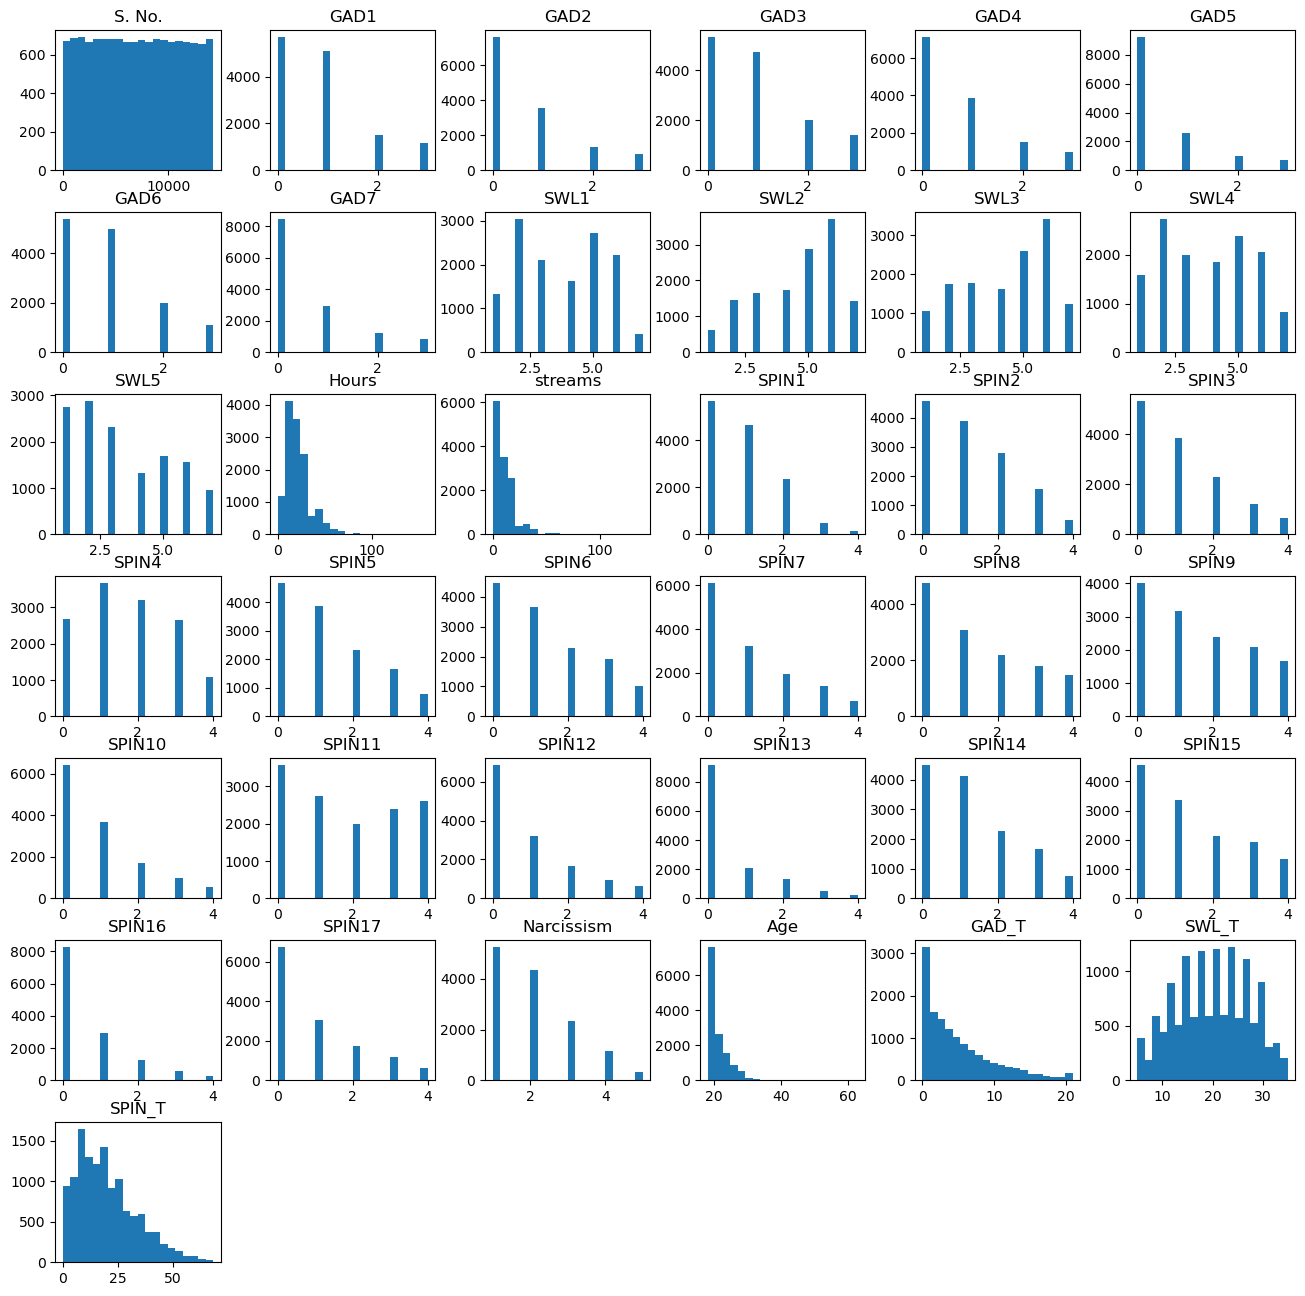

In [85]:
df.hist(figsize=(16,16), bins=20, grid=False);

In [50]:
df.isna().sum()

S. No.                0
GAD1                  0
GAD2                  0
GAD3                  0
GAD4                  0
GAD5                  0
GAD6                  0
GAD7                  0
GADE                649
SWL1                  0
SWL2                  0
SWL3                  0
SWL4                  0
SWL5                  0
Game                  0
Platform              0
Hours                30
earnings              0
whyplay               0
League             1838
streams             100
SPIN1               124
SPIN2               154
SPIN3               140
SPIN4               159
SPIN5               166
SPIN6               156
SPIN7               138
SPIN8               144
SPIN9               158
SPIN10              160
SPIN11              187
SPIN12              168
SPIN13              187
SPIN14              156
SPIN15              147
SPIN16              147
SPIN17              175
Narcissism           23
Gender                0
Age                   0
Work            

In [57]:
df.League.nunique()

1455

(0.0, 1670.0)

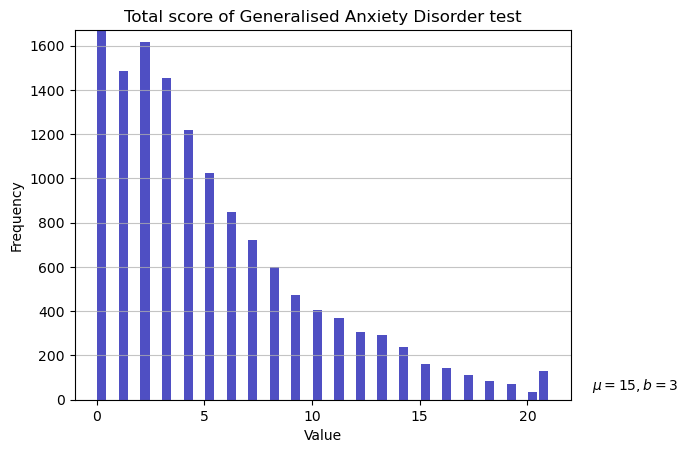

In [9]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=df.GAD_T, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Total score of Generalised Anxiety Disorder test')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

(0.0, 640.0)

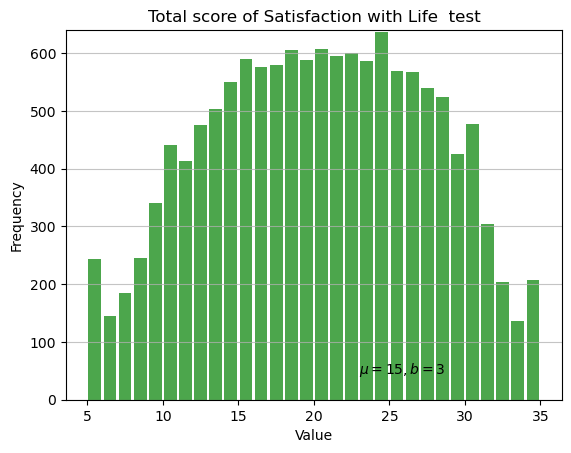

In [10]:
n, bins, patches = plt.hist(x=df.SWL_T, bins='auto', color='green',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Total score of Satisfaction with Life  test')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

(0.0, 860.0)

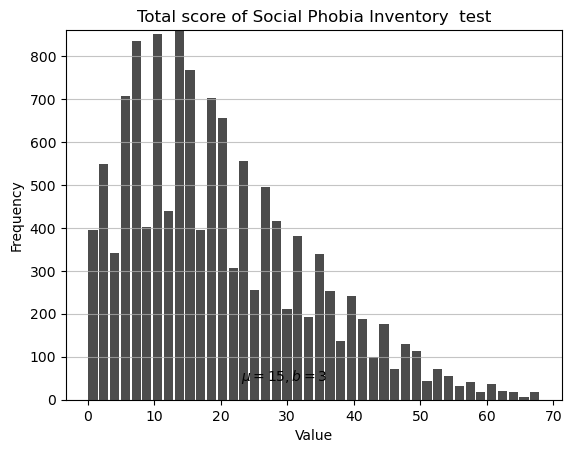

In [12]:
n, bins, patches = plt.hist(x=df.SPIN_T, bins='auto', color='black',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Total score of Social Phobia Inventory  test')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

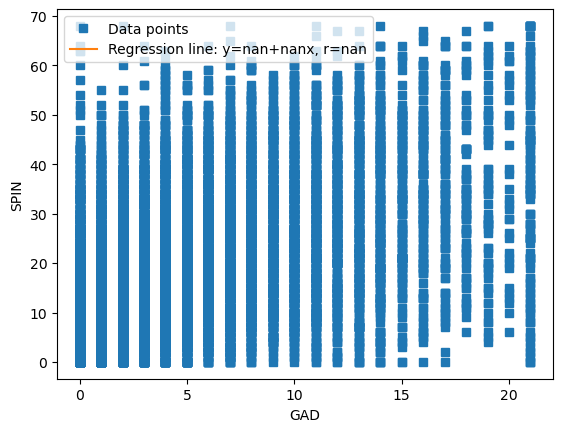

In [15]:
slope, intercept, r, p, stderr = scipy.stats.linregress(df.GAD_T, df.SPIN_T)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(df.GAD_T, df.SPIN_T, linewidth=0, marker='s', label='Data points')
ax.plot(df.GAD_T, intercept + slope * df.GAD_T, label=line)
ax.set_xlabel('GAD')
ax.set_ylabel('SPIN')
ax.legend(facecolor='white')
plt.show()

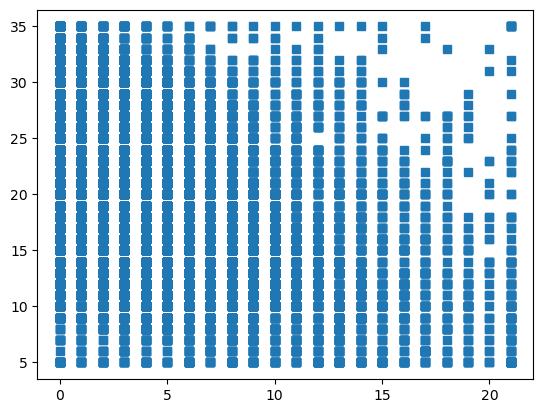

In [18]:
fig, ax = plt.subplots()
ax.plot(df.GAD_T, df.SWL_T, linewidth=0, marker='s', label='Data points')
plt.show()

In [20]:
columns_for_drop = ['GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7', 
                    'SWL1', 'SWL2', 'SWL3', 'SWL4', 'SWL5', 'SPIN1', 'SPIN2',
                    'SPIN3', 'SPIN4', 'SPIN5', 'SPIN6', 'SPIN7', 'SPIN8', 'SPIN9', 'SPIN10', 
                    'SPIN11', 'SPIN12', 'SPIN13', 'SPIN14', 'SPIN15', 'SPIN16', 'SPIN17']

In [23]:
df.drop(columns = columns_for_drop, inplace=True)

In [24]:
df.describe()

,S. No.,Hours,streams,Narcissism,Age,GAD_T,SWL_T,SPIN_T
count,13464.000000,13434.000000,13364.000000,13441.000000,13464.000000,13464.000000,13464.000000,12814.000000
mean,7096.839201,22.247357,11.233538,2.027677,20.930407,5.211973,19.788844,19.848525
std,4114.478220,70.284502,78.549209,1.061842,3.300897,4.713267,7.229243,13.467493
min,1.000000,0.000000,0.000000,1.000000,18.000000,0.000000,5.000000,0.000000
25%,3532.750000,12.000000,4.000000,1.000000,18.000000,2.000000,14.000000,9.000000
50%,7087.500000,20.000000,8.000000,2.000000,20.000000,4.000000,20.000000,17.000000
75%,10654.250000,28.000000,15.000000,3.000000,22.000000,8.000000,26.000000,28.000000
max,14250.000000,8000.000000,9001.000000,5.000000,63.000000,21.000000,35.000000,68.000000


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13464 entries, 0 to 13463
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   S. No.           13464 non-null  int64  
 1   GADE             12815 non-null  object 
 2   Game             13464 non-null  object 
 3   Platform         13464 non-null  object 
 4   Hours            13434 non-null  float64
 5   earnings         13464 non-null  object 
 6   whyplay          13464 non-null  object 
 7   League           11626 non-null  object 
 8   streams          13364 non-null  float64
 9   Narcissism       13441 non-null  float64
 10  Gender           13464 non-null  object 
 11  Age              13464 non-null  int64  
 12  Work             13426 non-null  object 
 13  Degree           13464 non-null  object 
 14  Birthplace       13464 non-null  object 
 15  Residence        13464 non-null  object 
 16  Reference        13449 non-null  object 
 17  Playstyle   